# Group Effect Regression Analysis

This notebook performs logistic regression analysis to examine group effects on sentiment expression in Chinese text data.

## Overview
- Analyzes sentiment bias between in-group ("we") and out-group ("they") expressions
- Uses progressive model fitting strategy to handle high-dimensional data
- Calculates odds ratios and confidence intervals
- Handles singular matrix issues automatically

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
import os
import sys
from contextlib import redirect_stdout
import io
import glob
import seaborn as sns

warnings.filterwarnings('ignore')

# Set Chinese font for matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
class GroupEffectAnalysis:
    def __init__(self, data_path=""):
        """
        Initialize group effect analysis - focused on odds ratios
        """
        self.data_path = data_path
        self.df = None
        self.results = {}
        
        # Extract method and model info from file path
        self.file_suffix = self._extract_file_suffix()
        
        # Initialize log storage
        self.log_content = []

    def _extract_file_suffix(self):
        """Extract method and model information from file path for output naming"""
        filename = os.path.basename(self.data_path)
        
        # Remove file extension
        base_name = os.path.splitext(filename)[0]
        
        # Extract suffix after "3.sentiment_data_"
        if "3.sentiment_data_" in base_name:
            suffix = base_name.replace("3.sentiment_data_", "")
            return suffix
        else:
            return "unknown"

    def log_print(self, *args, **kwargs):
        """Print to console and save to log"""
        # Convert all arguments to string and join them
        message = ' '.join(str(arg) for arg in args)
        
        # Print to console
        print(message, **kwargs)
        
        # Save to log
        self.log_content.append(message)

    def save_log(self, output_path=None):
        """Save all logged content to txt file"""
        if output_path is None:
            output_path = f"../result/4.regression_analysis_{self.file_suffix}.txt"
        
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write("=" * 60 + "\n")
            f.write("GROUP EFFECT REGRESSION ANALYSIS REPORT\n")
            f.write("=" * 60 + "\n")
            f.write(f"Data file: {self.data_path}\n")
            f.write(f"Analysis method/model: {self.file_suffix}\n")
            f.write("=" * 60 + "\n\n")
            
            for line in self.log_content:
                f.write(line + "\n")
        
        print(f"Analysis report saved to: {output_path}")
        return output_path

In [3]:
    def load_data(self):
        """Load sentiment analysis results"""
        self.log_print("Loading data...")
        self.df = pd.read_csv(self.data_path)
        self.log_print(f"Loaded {len(self.df)} records")
        return self.df

    def prepare_data(self):
        """Prepare data for analysis"""
        self.log_print(f"Group distribution: {self.df['source'].value_counts().to_dict()}")

        # Check for data quality issues
        self.diagnose_data()

        # Convert topic to categorical if it exists
        if 'topic' in self.df.columns:
            self.df['topic'] = self.df['topic'].astype('category')
            self.log_print(f"Topic distribution: {sorted(self.df['topic'].unique())}")

            # Show topic statistics (but don't preprocess)
            topic_counts = self.df['topic'].value_counts()
            self.log_print(f"Number of topics: {len(topic_counts)}")
            self.log_print(f"Topic sample size range: {topic_counts.min()} - {topic_counts.max()}")

            if len(topic_counts) > 50:
                self.log_print(
                    f"⚠️  Large number of topics ({len(topic_counts)}), will auto-simplify model if singular matrix occurs")

        return self.df

# Add methods to the class
GroupEffectAnalysis.load_data = load_data
GroupEffectAnalysis.prepare_data = prepare_data

In [4]:
    def diagnose_data(self):
        """Diagnose potential data issues that could cause singular matrix"""
        self.log_print("\n=== Data Diagnosis ===")

        # Check for perfect separation
        for outcome in ['pos', 'neg']:
            if outcome in self.df.columns:
                crosstab = pd.crosstab(self.df['source'], self.df[outcome])
                self.log_print(f"\n{outcome.upper()} by source distribution:")
                self.log_print(str(crosstab))

                # Check for zero cells (perfect separation)
                if (crosstab == 0).any().any():
                    self.log_print(f"⚠️  Warning: Zero cells detected in {outcome} crosstab")

                # Check for very low cell counts
                min_count = crosstab.min().min()
                if min_count < 5:
                    self.log_print(f"⚠️  Warning: Very low cell counts in {outcome} (min: {min_count})")

        # Check variable availability
        available_vars = []
        if 'total_tokens_scaled' in self.df.columns:
            available_vars.append('total_tokens_scaled')
        if 'TTR' in self.df.columns:
            available_vars.append('TTR')
        if 'topic' in self.df.columns:
            available_vars.append('topic')

        self.log_print(f"\nAvailable control variables: {available_vars}")

        # Check for multicollinearity among topics if they exist
        if 'topic' in self.df.columns:
            topic_counts = self.df['topic'].value_counts()
            self.log_print(f"Topic statistics: {len(topic_counts)} unique topics")
            self.log_print(
                f"Topic distribution: min={topic_counts.min()}, max={topic_counts.max()}, mean={topic_counts.mean():.1f}")

# Add method to the class
GroupEffectAnalysis.diagnose_data = diagnose_data

In [5]:
    def run_group_model(self, outcome='pos'):
        """
        Run logistic regression for group effects
        Progressive model fitting strategy, auto-downgrade when singular matrix occurs
        """
        self.log_print(f"\n=== {outcome.upper()} Sentiment Analysis ===")

        # Set reference group according to R logic
        if outcome == 'pos':
            reference_group = 'they'
            self.log_print("Reference group: 'they' (outgroup)")
        else:
            reference_group = 'we'
            self.log_print("Reference group: 'we' (ingroup)")

        # Create categorical source variable with specified reference
        self.df['source_cat'] = pd.Categorical(self.df['source'],
                                               categories=['we', 'they'])
        self.df['source_cat'] = self.df['source_cat'].cat.set_categories(
            [reference_group] + [cat for cat in ['we', 'they'] if cat != reference_group]
        )

        # Try different complexity models (following R code approach)
        model_configs = [
            {
                'name': 'Full model',
                'formula': self._build_full_formula(outcome),
                'description': 'including all available variables'
            },
            {
                'name': 'No-topic model',
                'formula': self._build_no_topic_formula(outcome),
                'description': 'excluding topic variables to avoid excessive parameters'
            },
            {
                'name': 'Basic model',
                'formula': f"{outcome} ~ source_cat",
                'description': 'only including group variables'
            }
        ]

        for config in model_configs:
            try:
                self.log_print(f"\nTrying {config['name']}: {config['description']}")
                self.log_print(f"Model formula: {config['formula']}")

                model = smf.logit(config['formula'], data=self.df).fit(disp=0)
                self.results[outcome] = model

                self.log_print(f"✅ {config['name']} fitted successfully")
                self._print_model_results(model, outcome, reference_group)
                return model

            except np.linalg.LinAlgError as e:
                self.log_print(f"❌ {config['name']} singular matrix error: {str(e)[:100]}...")
                self.log_print(f"   Continuing to next model...")
                continue

            except Exception as e:
                self.log_print(f"❌ {config['name']} other error: {str(e)[:100]}...")
                self.log_print(f"   Continuing to next model...")
                continue

        self.log_print("❌ All models failed to fit, please check data quality")
        return None

# Add method to the class
GroupEffectAnalysis.run_group_model = run_group_model

In [6]:
    def _build_full_formula(self, outcome):
        """Build complete model formula including all variables"""
        formula = f"{outcome} ~ source_cat"

        if 'total_tokens_scaled' in self.df.columns:
            formula += " + total_tokens_scaled"
        if 'TTR' in self.df.columns:
            formula += " + TTR"
        if 'topic' in self.df.columns:
            formula += " + C(topic)"

        return formula

    def _build_no_topic_formula(self, outcome):
        """Build model formula without topic variables"""
        formula = f"{outcome} ~ source_cat"

        if 'total_tokens_scaled' in self.df.columns:
            formula += " + total_tokens_scaled"
        if 'TTR' in self.df.columns:
            formula += " + TTR"

        return formula

# Add methods to the class
GroupEffectAnalysis._build_full_formula = _build_full_formula
GroupEffectAnalysis._build_no_topic_formula = _build_no_topic_formula

In [7]:
    def _print_model_results(self, model, outcome, reference_group):
        """Print model results"""
        # Find source coefficient
        source_param = None
        for param in model.params.index:
            if 'source_cat' in param and param != 'Intercept':
                source_param = param
                break

        if source_param:
            coef = model.params[source_param]
            se = model.bse[source_param]
            p_val = model.pvalues[source_param]
            odds_ratio = np.exp(coef)
            ci = np.exp(model.conf_int().loc[source_param])

            self.log_print(f"Coefficient: {coef:.4f} (SE: {se:.4f})")
            self.log_print(f"Odds Ratio: {odds_ratio:.4f} [95% CI: {ci[0]:.4f}-{ci[1]:.4f}]")
            self.log_print(f"P-value: {p_val:.4f}")

            # Interpret according to reference group
            if outcome == 'pos':
                if p_val < 0.05:
                    direction = "higher" if coef > 0 else "lower"
                    self.log_print(f"Result: Ingroup has {direction} positive sentiment than outgroup (p < 0.05)")
                else:
                    self.log_print(f"Result: No significant group difference (p = {p_val:.3f})")
            else:
                if p_val < 0.05:
                    direction = "higher" if coef > 0 else "lower"
                    self.log_print(f"Result: Outgroup has {direction} negative sentiment than ingroup (p < 0.05)")
                else:
                    self.log_print(f"Result: No significant group difference (p = {p_val:.3f})")
        else:
            self.log_print("⚠️  No source coefficient found in model")

# Add method to the class
GroupEffectAnalysis._print_model_results = _print_model_results

In [8]:
    def print_summary(self):
        """Print simple summary of all results"""
        self.log_print("\n" + "=" * 50)
        self.log_print("SUMMARY: Group Effect Analysis")
        self.log_print("=" * 50)

        for outcome in ['pos', 'neg']:
            if outcome in self.results:
                model = self.results[outcome]

                # Find source coefficient
                source_param = None
                for param in model.params.index:
                    if 'source_cat' in param and param != 'Intercept':
                        source_param = param
                        break

                if source_param:
                    coef = model.params[source_param]
                    p_val = model.pvalues[source_param]
                    odds_ratio = np.exp(coef)

                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                    self.log_print(f"{outcome.upper()}: OR = {odds_ratio:.3f}, p = {p_val:.3f} {sig}")

# Add method to the class
GroupEffectAnalysis.print_summary = print_summary

In [9]:
    def simple_plot(self, save_plot=True):
        """Create simple group comparison plot"""
        self.log_print("\nCreating visualization...")

        # Simple bar plot of sentiment rates
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        # Positive sentiment
        pos_rates = self.df.groupby('source')['pos'].mean()
        ax1.bar(pos_rates.index, pos_rates.values, alpha=0.7, color=['skyblue', 'lightcoral'])
        ax1.set_title('Positive Sentiment Rate by Group')
        ax1.set_ylabel('Rate')
        ax1.set_ylim(0, 1)

        # Negative sentiment
        neg_rates = self.df.groupby('source')['neg'].mean()
        ax2.bar(neg_rates.index, neg_rates.values, alpha=0.7, color=['skyblue', 'lightcoral'])
        ax2.set_title('Negative Sentiment Rate by Group')
        ax2.set_ylabel('Rate')
        ax2.set_ylim(0, 1)

        plt.tight_layout()
        if save_plot:
            plot_path = f'../result/4.group_effects_{self.file_suffix}.png'
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            self.log_print(f"Plot saved to: {plot_path}")
        plt.show()

# Add method to the class
GroupEffectAnalysis.simple_plot = simple_plot

## Run Analysis

Now let's execute the group effect analysis on sentiment data.

In [18]:
# Initialize analysis
print("=== Group Effect Analysis ===")

analysis = GroupEffectAnalysis(data_path="../result/3.sentiment_data_openai_gpt_4o_mini_3class.csv")

# Load and prepare data
analysis.load_data()
analysis.prepare_data()

print("\nData loaded and prepared successfully!")
print(f"Dataset shape: {analysis.df.shape}")
print(f"Columns: {list(analysis.df.columns)}")

=== Group Effect Analysis ===
Loading data...
Loaded 1945 records
Group distribution: {'we': 1208, 'they': 737}

=== Data Diagnosis ===

POS by source distribution:
pos       0    1
source          
they    392  345
we      432  776

NEG by source distribution:
neg        0   1
source          
they     693  44
we      1153  55

Available control variables: ['total_tokens_scaled', 'TTR', 'topic']
Topic statistics: 68 unique topics
Topic distribution: min=10, max=104, mean=28.6
Topic distribution: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
Number of topics: 68
Topic sample size range: 10 - 104
⚠️  Large number of topics (68), will auto-simplify model if singular matrix occurs

Data loaded and prepared successfully!
Dataset shape: (1945, 17)
Columns: ['text', 'source', '

In [19]:
# Run positive sentiment analysis
print("\n" + "="*60)
print("POSITIVE SENTIMENT ANALYSIS")
print("="*60)

pos_model = analysis.run_group_model('pos')


POSITIVE SENTIMENT ANALYSIS

=== POS Sentiment Analysis ===
Reference group: 'they' (outgroup)

Trying Full model: including all available variables
Model formula: pos ~ source_cat + total_tokens_scaled + TTR + C(topic)
❌ Full model singular matrix error: Singular matrix...
   Continuing to next model...

Trying No-topic model: excluding topic variables to avoid excessive parameters
Model formula: pos ~ source_cat + total_tokens_scaled + TTR
✅ No-topic model fitted successfully
Coefficient: 0.7330 (SE: 0.0961)
Odds Ratio: 2.0814 [95% CI: 1.7240-2.5129]
P-value: 0.0000
Result: Ingroup has higher positive sentiment than outgroup (p < 0.05)


In [21]:
# Run negative sentiment analysis
print("\n" + "="*60)
print("NEGATIVE SENTIMENT ANALYSIS")
print("="*60)

neg_model = analysis.run_group_model('neg')


NEGATIVE SENTIMENT ANALYSIS

=== NEG Sentiment Analysis ===
Reference group: 'we' (ingroup)

Trying Full model: including all available variables
Model formula: neg ~ source_cat + total_tokens_scaled + TTR + C(topic)
✅ Full model fitted successfully
Coefficient: 0.4016 (SE: 0.2592)
Odds Ratio: 1.4943 [95% CI: 0.8991-2.4836]
P-value: 0.1213
Result: No significant group difference (p = 0.121)


In [22]:
# Print summary of results
analysis.print_summary()


SUMMARY: Group Effect Analysis
POS: OR = 2.081, p = 0.000 ***
NEG: OR = 1.494, p = 0.121 ns



Creating visualization...
Plot saved to: ../result/4.group_effects_openai_gpt_4o_mini_3class.png


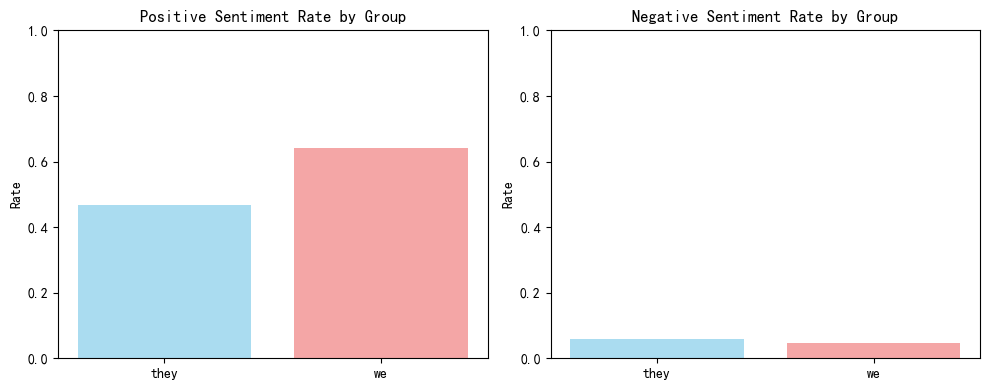

In [23]:
# Create visualization
analysis.simple_plot()

In [ ]:
# Save detailed report
report_path = analysis.save_log()
print(f"\nDetailed analysis report saved to: {report_path}")